In [1]:
# !pip install fastai2
# !pip install -Uqq fastbook
# !pip install fastai
# import fastbook
# fastbook.setup_book()
import datetime
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

In [2]:
# !pip install fastai -U;

import numpy as np;
import pandas as pd;
from pathlib import Path;
import seaborn as sns;
import matplotlib.pyplot as plt;
from PIL import Image;
import re;
# from google.colab import files;
from fastai import *;
from fastai.vision.all import *;
# defaults

In [6]:
path = Path("./recipes")
recipes_csv_url = "http://seppe.net/aa/assignment2/recipes.csv"
df = pd.read_csv(recipes_csv_url, sep=";")
print(f'Number of rows: {df.shape[0]}')
df.iloc[:,7:] = df.iloc[:,7:].astype(bool)
df['photo_id'] = df['photo_id'] + ".png"
df_no_encoded_values = df.iloc[:,0:7]
df_encoded_values = df.iloc[:,7:]

Number of rows: 11696


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Columns: 104 entries, photo_id to tag_strawberry
dtypes: bool(97), float64(1), int64(1), object(5)
memory usage: 1.7+ MB


In [8]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_healthy', 'tag_tasty', 'tag_dinner', 'tag_vegan', 'tag_breakfast',
        'tag_lunch', 'tag_dessert', 'tag_baking', 'tag_cake', 'tag_easyrecipes',
        'tag_chocolate', 'tag_vegetarian', 'tag_sweet', 'tag_pasta', 'tag_diet',
        'tag_fitness', 'tag_glutenfree', 'tag_chicken', 'tag_weightloss',
        'tag_veganfood', 'tag_plantbased', 'tag_cheese', 'tag_italianfood',
        'tag_salad', 'tag_keto', 'tag_pastry', 'tag_fresh', 'tag_snack',
        'tag_cookies', 'tag_comfortfood', 'tag_lowcarb', 'tag_protein',
        'tag_bread', 'tag_indianfood', 'tag_vegetables', 'tag_pizza',
        'tag_coffee', 'tag_bake', 'tag_desserts', 'tag_sweets', 'tag_soup',
        'tag_organic', 'tag_easy', 'tag_bakery', 'tag_fruit', 'tag_veggies',
        'tag_meat', 'tag_rice', 'tag_fish', 'tag_eggs', 'tag_breakfastideas',
        'tag_italy', 'tag_brunch', 'tag_veggie', 'tag_vegetarianrecipes',
        'tag_pancakes', 'tag_seafood', 'tag_baker', 'tag_veganrecipe',
        'tag_dair

## The raw label counts of the dataset (without any preprocessing)

<AxesSubplot:xlabel='index', ylabel='count'>

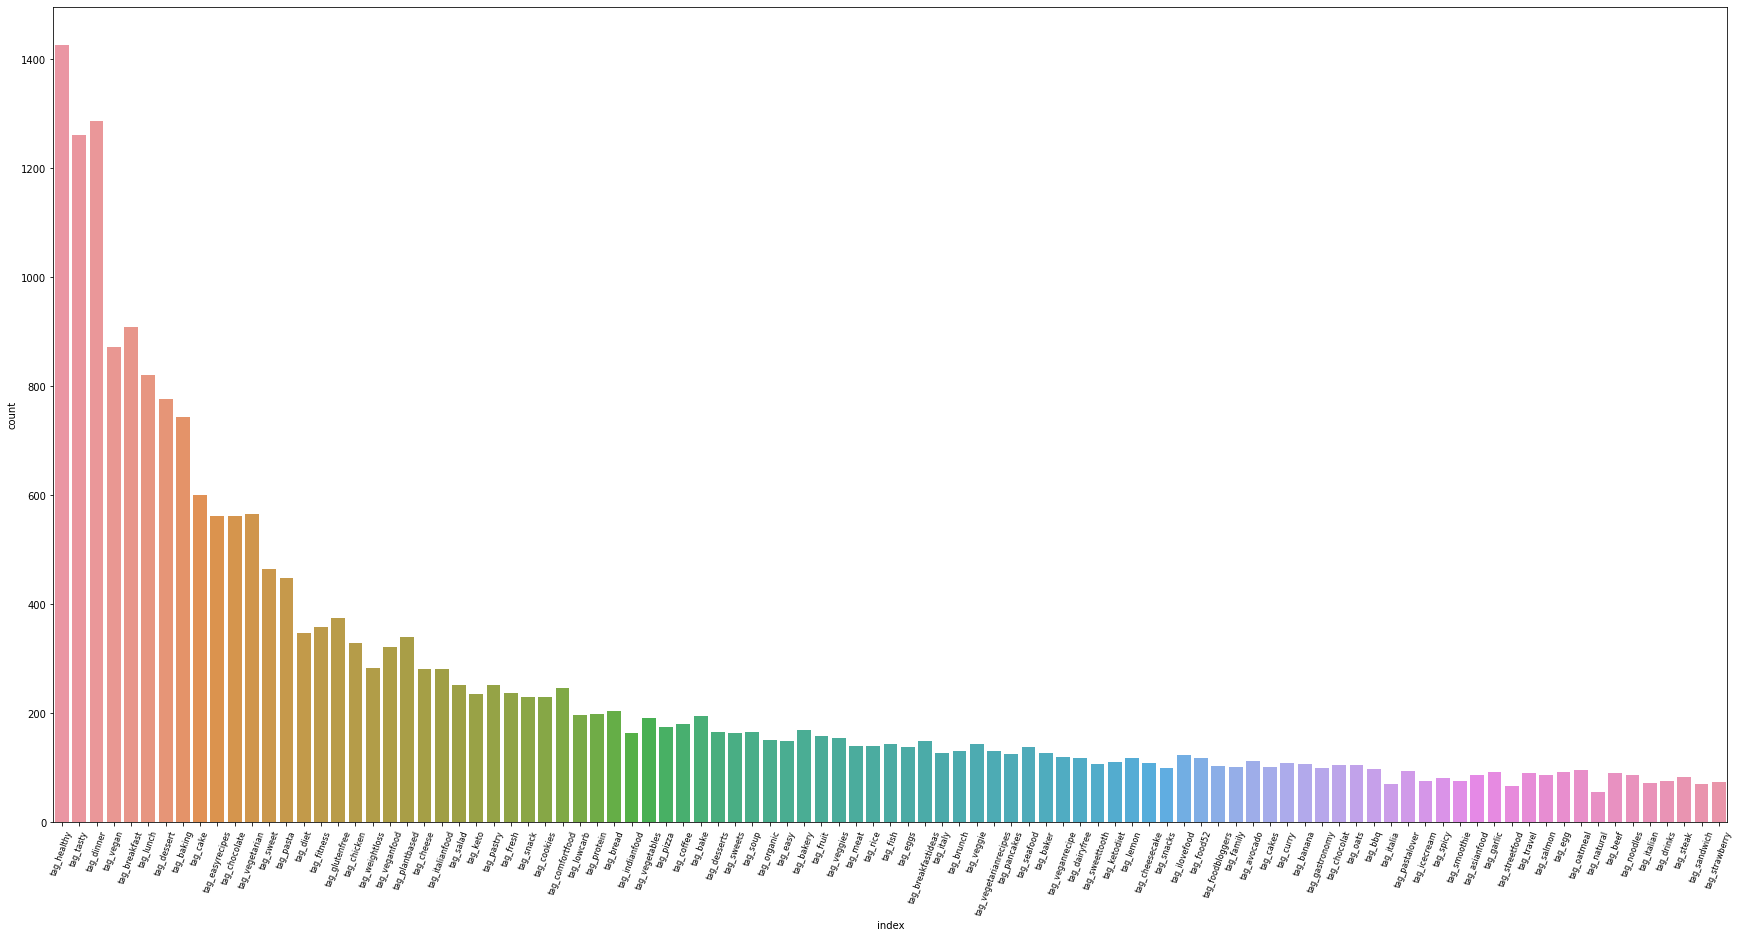

In [9]:
counts = pd.DataFrame(df.iloc[:,7:].sum(axis=0),columns=['count'])
counts.reset_index(inplace=True)

plt.figure(figsize=(30,15))
plt.xticks(rotation=70, size=8)
sns.barplot(x=counts['index'], y=counts['count'])

In [10]:
# checking the number of rows that have no tags before preprocessing the data
c=0
df_t = df.iloc[:,7:]
for row in range(11696):
    if df_t.iloc[row].sum()==0:
        c+=1
print(c)

3822


_____________
### Grouping the vegan-ish columns

In [11]:
veg_mask = ((df.tag_vegan) | 
            (df.tag_vegetarian) |
            (df.tag_veganfood) | 
            (df.tag_vegetables) | 
            (df.tag_veggies) |
            (df.tag_veggie) | 
            (df.tag_vegetarianrecipes) |
            (df.tag_veganrecipe))
(veg_mask.sum(),df.loc[veg_mask])

(1490,
               photo_id                                       url  \
 0      CMPELQqh_nh.png  https://www.instagram.com/p/CMPELQqh_nh/   
 1      CMPEHqppR-t.png  https://www.instagram.com/p/CMPEHqppR-t/   
 2      CMPEBY9Buko.png  https://www.instagram.com/p/CMPEBY9Buko/   
 8      CMPD0mIlCLw.png  https://www.instagram.com/p/CMPD0mIlCLw/   
 9      CMPDz9chdgz.png  https://www.instagram.com/p/CMPDz9chdgz/   
 ...                ...                                       ...   
 11673  CMsPHKCJ1CQ.png  https://www.instagram.com/p/CMsPHKCJ1CQ/   
 11675  CMsPFvGlXlh.png  https://www.instagram.com/p/CMsPFvGlXlh/   
 11679  CMsPDtsBkA7.png  https://www.instagram.com/p/CMsPDtsBkA7/   
 11685  CMsO7dvnom-.png  https://www.instagram.com/p/CMsO7dvnom-/   
 11687  CMsO299HfsC.png  https://www.instagram.com/p/CMsO299HfsC/   
 
                                may_be  likes            timestamp  \
 0                  dessert and indoor      3  2021-03-10T10:47:18   
 1                    p

In [12]:
df['tag_veg_sum'] = False
df.loc[veg_mask, 'tag_veg_sum'] = True
df.drop(labels=['tag_vegan', 'tag_vegetarian', 'tag_veganfood', 'tag_vegetables', 
                'tag_veggies', 'tag_veggie', 'tag_vegetarianrecipes','tag_veganrecipe'], axis=1, inplace=True)

In [13]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_healthy', 'tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_dessert', 'tag_baking', 'tag_cake', 'tag_easyrecipes',
        'tag_chocolate', 'tag_sweet', 'tag_pasta', 'tag_diet', 'tag_fitness',
        'tag_glutenfree', 'tag_chicken', 'tag_weightloss', 'tag_plantbased',
        'tag_cheese', 'tag_italianfood', 'tag_salad', 'tag_keto', 'tag_pastry',
        'tag_fresh', 'tag_snack', 'tag_cookies', 'tag_comfortfood',
        'tag_lowcarb', 'tag_protein', 'tag_bread', 'tag_indianfood',
        'tag_pizza', 'tag_coffee', 'tag_bake', 'tag_desserts', 'tag_sweets',
        'tag_soup', 'tag_organic', 'tag_easy', 'tag_bakery', 'tag_fruit',
        'tag_meat', 'tag_rice', 'tag_fish', 'tag_eggs', 'tag_breakfastideas',
        'tag_italy', 'tag_brunch', 'tag_pancakes', 'tag_seafood', 'tag_baker',
        'tag_dairyfree', 'tag_sweettooth', 'tag_ketodiet', 'tag_lemon',
        'tag_cheesecake', 'tag_snacks', 'tag_ilovefood', 'tag_food52',
        'tag_foodbloggers', '

________
### Grouping the bakish columns

In [14]:
bake_mask = ((df.tag_baking) | 
            (df.tag_cake) |
            (df.tag_bread) | 
            (df.tag_bake) | 
            (df.tag_bakery) |
            (df.tag_baker) | 
            (df.tag_cakes) |
             (df.tag_pastry))
(bake_mask.sum(),df.loc[bake_mask])

(1505,
               photo_id                                       url  \
 2      CMPEBY9Buko.png  https://www.instagram.com/p/CMPEBY9Buko/   
 12     CMPDpeDp6Qr.png  https://www.instagram.com/p/CMPDpeDp6Qr/   
 16     CMPDgtknaSS.png  https://www.instagram.com/p/CMPDgtknaSS/   
 50     CMPB4X3jjaL.png  https://www.instagram.com/p/CMPB4X3jjaL/   
 65     CMPBSqoFsEo.png  https://www.instagram.com/p/CMPBSqoFsEo/   
 ...                ...                                       ...   
 11662  CMsPpzIjjTm.png  https://www.instagram.com/p/CMsPpzIjjTm/   
 11670  CMsPPp8BUsm.png  https://www.instagram.com/p/CMsPPp8BUsm/   
 11674  CMsPGAkJVR9.png  https://www.instagram.com/p/CMsPGAkJVR9/   
 11691  CMsOtSZhtSx.png  https://www.instagram.com/p/CMsOtSZhtSx/   
 11695  CMsOZ0MpBbu.png  https://www.instagram.com/p/CMsOZ0MpBbu/   
 
                                may_be  likes            timestamp  \
 2                     cake and indoor      2  2021-03-10T10:45:57   
 12                    

In [15]:
df['tag_bake_sum'] = False
df.loc[bake_mask, 'tag_bake_sum'] = True
df.drop(labels=['tag_baking', 'tag_cake', 'tag_bread', 'tag_bake', 'tag_bakery', 'tag_baker', 'tag_cakes', 'tag_pastry'], axis=1, inplace=True)

In [16]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_healthy', 'tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_dessert', 'tag_easyrecipes', 'tag_chocolate', 'tag_sweet',
        'tag_pasta', 'tag_diet', 'tag_fitness', 'tag_glutenfree', 'tag_chicken',
        'tag_weightloss', 'tag_plantbased', 'tag_cheese', 'tag_italianfood',
        'tag_salad', 'tag_keto', 'tag_fresh', 'tag_snack', 'tag_cookies',
        'tag_comfortfood', 'tag_lowcarb', 'tag_protein', 'tag_indianfood',
        'tag_pizza', 'tag_coffee', 'tag_desserts', 'tag_sweets', 'tag_soup',
        'tag_organic', 'tag_easy', 'tag_fruit', 'tag_meat', 'tag_rice',
        'tag_fish', 'tag_eggs', 'tag_breakfastideas', 'tag_italy', 'tag_brunch',
        'tag_pancakes', 'tag_seafood', 'tag_dairyfree', 'tag_sweettooth',
        'tag_ketodiet', 'tag_lemon', 'tag_cheesecake', 'tag_snacks',
        'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
        'tag_avocado', 'tag_curry', 'tag_banana', 'tag_gastronomy',
        'tag_chocolat', 'ta

________
### Grouping the healthy/diet

In [17]:
diet_mask = ((df.tag_healthy) | 
             (df.tag_diet) |
             (df.tag_fitness) | 
             (df.tag_weightloss) | 
             (df.tag_plantbased) |
             (df.tag_salad) | 
             (df.tag_keto)  |
             (df.tag_lowcarb) |
             (df.tag_organic) |
             (df.tag_ketodiet) |
             (df.tag_oats) |
             (df.tag_oatmeal) |
             (df.tag_protein)) 
# 'tag_natural' does not work well with these
(diet_mask.sum(),df.loc[diet_mask])

(2529,
               photo_id                                       url  \
 0      CMPELQqh_nh.png  https://www.instagram.com/p/CMPELQqh_nh/   
 2      CMPEBY9Buko.png  https://www.instagram.com/p/CMPEBY9Buko/   
 5      CMPD5YEAmHv.png  https://www.instagram.com/p/CMPD5YEAmHv/   
 6      CMPD3whhZvD.png  https://www.instagram.com/p/CMPD3whhZvD/   
 7      CMPD1lBJbbq.png  https://www.instagram.com/p/CMPD1lBJbbq/   
 ...                ...                                       ...   
 11675  CMsPFvGlXlh.png  https://www.instagram.com/p/CMsPFvGlXlh/   
 11679  CMsPDtsBkA7.png  https://www.instagram.com/p/CMsPDtsBkA7/   
 11685  CMsO7dvnom-.png  https://www.instagram.com/p/CMsO7dvnom-/   
 11687  CMsO299HfsC.png  https://www.instagram.com/p/CMsO299HfsC/   
 11689  CMsOzKOghl4.png  https://www.instagram.com/p/CMsOzKOghl4/   
 
                                may_be  likes            timestamp  \
 0                  dessert and indoor      3  2021-03-10T10:47:18   
 2                     

In [18]:
df['tag_diet_sum'] = False
df.loc[diet_mask, 'tag_diet_sum'] = True
df.drop(labels=['tag_healthy', 'tag_diet', 'tag_fitness', 'tag_weightloss', 'tag_plantbased', 'tag_salad', 
                'tag_keto', 'tag_lowcarb', 'tag_organic' , 'tag_ketodiet', 'tag_oats', 'tag_oatmeal', 'tag_protein'], axis=1, inplace=True)

In [19]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch', 'tag_dessert',
        'tag_easyrecipes', 'tag_chocolate', 'tag_sweet', 'tag_pasta',
        'tag_glutenfree', 'tag_chicken', 'tag_cheese', 'tag_italianfood',
        'tag_fresh', 'tag_snack', 'tag_cookies', 'tag_comfortfood',
        'tag_indianfood', 'tag_pizza', 'tag_coffee', 'tag_desserts',
        'tag_sweets', 'tag_soup', 'tag_easy', 'tag_fruit', 'tag_meat',
        'tag_rice', 'tag_fish', 'tag_eggs', 'tag_breakfastideas', 'tag_italy',
        'tag_brunch', 'tag_pancakes', 'tag_seafood', 'tag_dairyfree',
        'tag_sweettooth', 'tag_lemon', 'tag_cheesecake', 'tag_snacks',
        'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
        'tag_avocado', 'tag_curry', 'tag_banana', 'tag_gastronomy',
        'tag_chocolat', 'tag_bbq', 'tag_italia', 'tag_pastalover',
        'tag_icecream', 'tag_spicy', 'tag_smoothie', 'tag_asianfood',
        'tag_garlic', 'tag_streetfood', 'tag_travel', 'tag_salmon', 't

##

________
### Grouping sweets 

In [20]:
sweets_mask= ((df.tag_dessert) | 
             (df.tag_chocolate) |
             (df.tag_sweet) | 
             (df.tag_desserts) | 
             (df.tag_sweets) |
             (df.tag_pancakes) | 
             (df.tag_sweettooth)  |
             (df.tag_cheesecake) |
             (df.tag_icecream) |
             (df.tag_chocolat))
(sweets_mask.sum(),df.loc[sweets_mask])

(1689,
               photo_id                                       url  \
 4      CMPD73jJssJ.png  https://www.instagram.com/p/CMPD73jJssJ/   
 6      CMPD3whhZvD.png  https://www.instagram.com/p/CMPD3whhZvD/   
 16     CMPDgtknaSS.png  https://www.instagram.com/p/CMPDgtknaSS/   
 27     CMPDLoZlOTV.png  https://www.instagram.com/p/CMPDLoZlOTV/   
 30     CMPCsw9JyUr.png  https://www.instagram.com/p/CMPCsw9JyUr/   
 ...                ...                                       ...   
 11661  CMsPq1tFcxc.png  https://www.instagram.com/p/CMsPq1tFcxc/   
 11668  CMsPQq5hTqy.png  https://www.instagram.com/p/CMsPQq5hTqy/   
 11670  CMsPPp8BUsm.png  https://www.instagram.com/p/CMsPPp8BUsm/   
 11690  CMsOuc5no2N.png  https://www.instagram.com/p/CMsOuc5no2N/   
 11692  CMsOstJAXEJ.png  https://www.instagram.com/p/CMsOstJAXEJ/   
 
                                may_be  likes            timestamp  \
 4                             dessert      2  2021-03-10T10:45:12   
 6      strawberry, des

In [21]:
df['tag_sweets_sum'] = False
df.loc[sweets_mask, 'tag_sweets_sum'] = True
df.drop(labels=['tag_dessert', 'tag_chocolate', 'tag_chocolat', 'tag_sweet', 'tag_desserts', 'tag_sweets', 'tag_pancakes', 
                'tag_sweettooth', 'tag_cheesecake', 'tag_icecream'], axis=1, inplace=True)

In [22]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_pasta', 'tag_glutenfree', 'tag_chicken',
        'tag_cheese', 'tag_italianfood', 'tag_fresh', 'tag_snack',
        'tag_cookies', 'tag_comfortfood', 'tag_indianfood', 'tag_pizza',
        'tag_coffee', 'tag_soup', 'tag_easy', 'tag_fruit', 'tag_meat',
        'tag_rice', 'tag_fish', 'tag_eggs', 'tag_breakfastideas', 'tag_italy',
        'tag_brunch', 'tag_seafood', 'tag_dairyfree', 'tag_lemon', 'tag_snacks',
        'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
        'tag_avocado', 'tag_curry', 'tag_banana', 'tag_gastronomy', 'tag_bbq',
        'tag_italia', 'tag_pastalover', 'tag_spicy', 'tag_smoothie',
        'tag_asianfood', 'tag_garlic', 'tag_streetfood', 'tag_travel',
        'tag_salmon', 'tag_egg', 'tag_natural', 'tag_beef', 'tag_noodles',
        'tag_italian', 'tag_drinks', 'tag_steak', 'tag_sandwich',
        'tag_strawberry', 'tag_veg_sum', 'tag_bake_sum', '

________
### Grouping meat 

In [23]:
meat_mask= ((df.tag_chicken) | 
             (df.tag_meat) |
             (df.tag_beef) |
             (df.tag_steak))
  
(meat_mask.sum(),df.loc[meat_mask])

(561,
               photo_id                                       url  \
 36     CMPCmZdHCcY.png  https://www.instagram.com/p/CMPCmZdHCcY/   
 42     CMPCOauKjrK.png  https://www.instagram.com/p/CMPCOauKjrK/   
 116    CMPABvBJcyc.png  https://www.instagram.com/p/CMPABvBJcyc/   
 149    CMO--onATy0.png  https://www.instagram.com/p/CMO--onATy0/   
 157    CMO-xUose_b.png  https://www.instagram.com/p/CMO-xUose_b/   
 ...                ...                                       ...   
 11624  CMruJwZgvS1.png  https://www.instagram.com/p/CMruJwZgvS1/   
 11634  CMsQbTJpw3i.png  https://www.instagram.com/p/CMsQbTJpw3i/   
 11647  CMsQAfQjfL8.png  https://www.instagram.com/p/CMsQAfQjfL8/   
 11655  CMrvaGpDhl6.png  https://www.instagram.com/p/CMrvaGpDhl6/   
 11682  CMsO-nShXC3.png  https://www.instagram.com/p/CMsO-nShXC3/   
 
                      may_be  likes            timestamp           scraped_at  \
 36     chow mein and indoor      2  2021-03-10T10:33:32  2021-03-10T11:52:49   
 4

In [24]:
df['tag_meat_sum'] = False
df.loc[meat_mask, 'tag_meat_sum'] = True
df.drop(labels=['tag_chicken', 'tag_meat', 'tag_beef', 'tag_steak'], axis=1, inplace=True)

In [25]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_pasta', 'tag_glutenfree', 'tag_cheese',
        'tag_italianfood', 'tag_fresh', 'tag_snack', 'tag_cookies',
        'tag_comfortfood', 'tag_indianfood', 'tag_pizza', 'tag_coffee',
        'tag_soup', 'tag_easy', 'tag_fruit', 'tag_rice', 'tag_fish', 'tag_eggs',
        'tag_breakfastideas', 'tag_italy', 'tag_brunch', 'tag_seafood',
        'tag_dairyfree', 'tag_lemon', 'tag_snacks', 'tag_ilovefood',
        'tag_food52', 'tag_foodbloggers', 'tag_family', 'tag_avocado',
        'tag_curry', 'tag_banana', 'tag_gastronomy', 'tag_bbq', 'tag_italia',
        'tag_pastalover', 'tag_spicy', 'tag_smoothie', 'tag_asianfood',
        'tag_garlic', 'tag_streetfood', 'tag_travel', 'tag_salmon', 'tag_egg',
        'tag_natural', 'tag_noodles', 'tag_italian', 'tag_drinks',
        'tag_sandwich', 'tag_strawberry', 'tag_veg_sum', 'tag_bake_sum',
        'tag_diet_sum', 'tag_sweets_sum', 'tag_meat_sum'],
  

________
### Grouping italian food 

In [26]:
italian_mask= ((df.tag_pasta) | 
             (df.tag_italianfood) |
             (df.tag_pizza) | 
             (df.tag_italy) | 
             (df.tag_italia) |
             (df.tag_pastalover) | 
             (df.tag_italian))
(italian_mask.sum(),df.loc[italian_mask])

(874,
               photo_id                                       url  \
 14     CMPDn1oDxJA.png  https://www.instagram.com/p/CMPDn1oDxJA/   
 16     CMPDgtknaSS.png  https://www.instagram.com/p/CMPDgtknaSS/   
 19     CMPDfbQnqDF.png  https://www.instagram.com/p/CMPDfbQnqDF/   
 24     CMPDYtDhqVV.png  https://www.instagram.com/p/CMPDYtDhqVV/   
 28     CMPC5ODlMip.png  https://www.instagram.com/p/CMPC5ODlMip/   
 ...                ...                                       ...   
 11642  CMsQNIrhuQY.png  https://www.instagram.com/p/CMsQNIrhuQY/   
 11653  CMsPw-qpmvQ.png  https://www.instagram.com/p/CMsPw-qpmvQ/   
 11656  CLcZTwNlPFd.png  https://www.instagram.com/p/CLcZTwNlPFd/   
 11664  CMsPi4Fhv0C.png  https://www.instagram.com/p/CMsPi4Fhv0C/   
 11681  CMsO_DmlujV.png  https://www.instagram.com/p/CMsO_DmlujV/   
 
                         may_be  likes            timestamp  \
 14             food and indoor     26  2021-03-10T10:42:44   
 16             cake and indoor      3

In [27]:
df['tag_italian_sum'] = False
df.loc[italian_mask, 'tag_italian_sum'] = True
df.drop(labels=['tag_pasta', 'tag_italianfood', 'tag_pizza', 'tag_italy', 'tag_italia', 'tag_pastalover', 'tag_italian'], axis=1, inplace=True)

In [28]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_glutenfree', 'tag_cheese', 'tag_fresh',
        'tag_snack', 'tag_cookies', 'tag_comfortfood', 'tag_indianfood',
        'tag_coffee', 'tag_soup', 'tag_easy', 'tag_fruit', 'tag_rice',
        'tag_fish', 'tag_eggs', 'tag_breakfastideas', 'tag_brunch',
        'tag_seafood', 'tag_dairyfree', 'tag_lemon', 'tag_snacks',
        'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
        'tag_avocado', 'tag_curry', 'tag_banana', 'tag_gastronomy', 'tag_bbq',
        'tag_spicy', 'tag_smoothie', 'tag_asianfood', 'tag_garlic',
        'tag_streetfood', 'tag_travel', 'tag_salmon', 'tag_egg', 'tag_natural',
        'tag_noodles', 'tag_drinks', 'tag_sandwich', 'tag_strawberry',
        'tag_veg_sum', 'tag_bake_sum', 'tag_diet_sum', 'tag_sweets_sum',
        'tag_meat_sum', 'tag_italian_sum'],
       dtype='object'),
 53)

________
### Grouping seafood

In [29]:
seafood_mask= ((df.tag_fish) | 
             (df.tag_seafood) |
             (df.tag_salmon))
(seafood_mask.sum(),df.loc[seafood_mask])

(300,
               photo_id                                       url  \
 139    CMO_HQhB-dI.png  https://www.instagram.com/p/CMO_HQhB-dI/   
 151    CMO-4GNqxnv.png  https://www.instagram.com/p/CMO-4GNqxnv/   
 245    CMO7SZ0g2LG.png  https://www.instagram.com/p/CMO7SZ0g2LG/   
 289    CMO5KEcl7WD.png  https://www.instagram.com/p/CMO5KEcl7WD/   
 321    CMO3lbkhLk-.png  https://www.instagram.com/p/CMO3lbkhLk-/   
 ...                ...                                       ...   
 11605  CMsRIkpDvlv.png  https://www.instagram.com/p/CMsRIkpDvlv/   
 11622  CMsQreIBHhi.png  https://www.instagram.com/p/CMsQreIBHhi/   
 11636  CMsQZCyFFmx.png  https://www.instagram.com/p/CMsQZCyFFmx/   
 11659  CMsPujqMp1Q.png  https://www.instagram.com/p/CMsPujqMp1Q/   
 11664  CMsPi4Fhv0C.png  https://www.instagram.com/p/CMsPi4Fhv0C/   
 
                      may_be  likes            timestamp           scraped_at  \
 139         food and indoor      9  2021-03-10T10:03:04  2021-03-10T12:04:34   
 1

In [30]:
df['tag_seafood_sum'] = False
df.loc[seafood_mask, 'tag_seafood_sum'] = True
df.drop(labels=['tag_fish', 'tag_seafood', 'tag_salmon'], axis=1, inplace=True)

In [31]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_glutenfree', 'tag_cheese', 'tag_fresh',
        'tag_snack', 'tag_cookies', 'tag_comfortfood', 'tag_indianfood',
        'tag_coffee', 'tag_soup', 'tag_easy', 'tag_fruit', 'tag_rice',
        'tag_eggs', 'tag_breakfastideas', 'tag_brunch', 'tag_dairyfree',
        'tag_lemon', 'tag_snacks', 'tag_ilovefood', 'tag_food52',
        'tag_foodbloggers', 'tag_family', 'tag_avocado', 'tag_curry',
        'tag_banana', 'tag_gastronomy', 'tag_bbq', 'tag_spicy', 'tag_smoothie',
        'tag_asianfood', 'tag_garlic', 'tag_streetfood', 'tag_travel',
        'tag_egg', 'tag_natural', 'tag_noodles', 'tag_drinks', 'tag_sandwich',
        'tag_strawberry', 'tag_veg_sum', 'tag_bake_sum', 'tag_diet_sum',
        'tag_sweets_sum', 'tag_meat_sum', 'tag_italian_sum', 'tag_seafood_sum'],
       dtype='object'),
 51)

________
### Grouping fruit

In [32]:
fruit_mask= ((df.tag_fruit) | 
             (df.tag_avocado) |
             (df.tag_banana) |
             (df.tag_smoothie) |
             (df.tag_strawberry))
(fruit_mask.sum(),df.loc[fruit_mask])

(465,
               photo_id                                       url  \
 0      CMPELQqh_nh.png  https://www.instagram.com/p/CMPELQqh_nh/   
 6      CMPD3whhZvD.png  https://www.instagram.com/p/CMPD3whhZvD/   
 8      CMPD0mIlCLw.png  https://www.instagram.com/p/CMPD0mIlCLw/   
 9      CMPDz9chdgz.png  https://www.instagram.com/p/CMPDz9chdgz/   
 33     CMOfTsap33s.png  https://www.instagram.com/p/CMOfTsap33s/   
 ...                ...                                       ...   
 11611  CMsQ6bfhSgI.png  https://www.instagram.com/p/CMsQ6bfhSgI/   
 11635  CMsQZ2zBhxM.png  https://www.instagram.com/p/CMsQZ2zBhxM/   
 11672  CMsPIKSFtG-.png  https://www.instagram.com/p/CMsPIKSFtG-/   
 11679  CMsPDtsBkA7.png  https://www.instagram.com/p/CMsPDtsBkA7/   
 11695  CMsOZ0MpBbu.png  https://www.instagram.com/p/CMsOZ0MpBbu/   
 
                                may_be  likes            timestamp  \
 0                  dessert and indoor      3  2021-03-10T10:47:18   
 6      strawberry, dess

In [33]:
df['tag_fruit_sum'] = False
df.loc[fruit_mask, 'tag_fruit_sum'] = True
df.drop(labels=['tag_fruit', 'tag_avocado', 'tag_banana', 'tag_smoothie', 'tag_strawberry'], axis=1, inplace=True)

In [34]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_glutenfree', 'tag_cheese', 'tag_fresh',
        'tag_snack', 'tag_cookies', 'tag_comfortfood', 'tag_indianfood',
        'tag_coffee', 'tag_soup', 'tag_easy', 'tag_rice', 'tag_eggs',
        'tag_breakfastideas', 'tag_brunch', 'tag_dairyfree', 'tag_lemon',
        'tag_snacks', 'tag_ilovefood', 'tag_food52', 'tag_foodbloggers',
        'tag_family', 'tag_curry', 'tag_gastronomy', 'tag_bbq', 'tag_spicy',
        'tag_asianfood', 'tag_garlic', 'tag_streetfood', 'tag_travel',
        'tag_egg', 'tag_natural', 'tag_noodles', 'tag_drinks', 'tag_sandwich',
        'tag_veg_sum', 'tag_bake_sum', 'tag_diet_sum', 'tag_sweets_sum',
        'tag_meat_sum', 'tag_italian_sum', 'tag_seafood_sum', 'tag_fruit_sum'],
       dtype='object'),
 47)

________
### Grouping ethnic food

In [35]:
ethnic_mask= ((df.tag_indianfood) | 
             (df.tag_rice) |
             (df.tag_curry) |
             (df.tag_spicy) |
             (df.tag_asianfood) |
             (df.tag_garlic))
(ethnic_mask.sum(),df.loc[ethnic_mask])

(597,
               photo_id                                       url  \
 11     CMPDqnRnC6R.png  https://www.instagram.com/p/CMPDqnRnC6R/   
 35     CMMqLGmBzII.png  https://www.instagram.com/p/CMMqLGmBzII/   
 36     CMPCmZdHCcY.png  https://www.instagram.com/p/CMPCmZdHCcY/   
 53     CMPBqqMhVyK.png  https://www.instagram.com/p/CMPBqqMhVyK/   
 57     CMPBlXtFjfK.png  https://www.instagram.com/p/CMPBlXtFjfK/   
 ...                ...                                       ...   
 11636  CMsQZCyFFmx.png  https://www.instagram.com/p/CMsQZCyFFmx/   
 11642  CMsQNIrhuQY.png  https://www.instagram.com/p/CMsQNIrhuQY/   
 11647  CMsQAfQjfL8.png  https://www.instagram.com/p/CMsQAfQjfL8/   
 11685  CMsO7dvnom-.png  https://www.instagram.com/p/CMsO7dvnom-/   
 11695  CMsOZ0MpBbu.png  https://www.instagram.com/p/CMsOZ0MpBbu/   
 
                      may_be  likes            timestamp           scraped_at  \
 11     chow mein and indoor      6  2021-03-10T10:42:50  2021-03-10T11:49:54   
 3

In [36]:
df['tag_ethnic_sum'] = False
df.loc[ethnic_mask, 'tag_ethnic_sum'] = True
df.drop(labels=['tag_indianfood', 'tag_rice', 'tag_curry', 'tag_spicy', 'tag_asianfood', 'tag_garlic'], axis=1, inplace=True)

In [37]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_easyrecipes', 'tag_glutenfree', 'tag_cheese', 'tag_fresh',
        'tag_snack', 'tag_cookies', 'tag_comfortfood', 'tag_coffee', 'tag_soup',
        'tag_easy', 'tag_eggs', 'tag_breakfastideas', 'tag_brunch',
        'tag_dairyfree', 'tag_lemon', 'tag_snacks', 'tag_ilovefood',
        'tag_food52', 'tag_foodbloggers', 'tag_family', 'tag_gastronomy',
        'tag_bbq', 'tag_streetfood', 'tag_travel', 'tag_egg', 'tag_natural',
        'tag_noodles', 'tag_drinks', 'tag_sandwich', 'tag_veg_sum',
        'tag_bake_sum', 'tag_diet_sum', 'tag_sweets_sum', 'tag_meat_sum',
        'tag_italian_sum', 'tag_seafood_sum', 'tag_fruit_sum',
        'tag_ethnic_sum'],
       dtype='object'),
 42)

________
### Grouping easy

In [38]:
easy_mask= ((df.tag_easyrecipes) | 
             (df.tag_snack) |
             (df.tag_cookies) |
             (df.tag_comfortfood) |
             (df.tag_snacks))
(easy_mask.sum(),df.loc[easy_mask])

(1255,
               photo_id                                       url  \
 4      CMPD73jJssJ.png  https://www.instagram.com/p/CMPD73jJssJ/   
 8      CMPD0mIlCLw.png  https://www.instagram.com/p/CMPD0mIlCLw/   
 22     CMPDd0lnnMm.png  https://www.instagram.com/p/CMPDd0lnnMm/   
 27     CMPDLoZlOTV.png  https://www.instagram.com/p/CMPDLoZlOTV/   
 35     CMMqLGmBzII.png  https://www.instagram.com/p/CMMqLGmBzII/   
 ...                ...                                       ...   
 11647  CMsQAfQjfL8.png  https://www.instagram.com/p/CMsQAfQjfL8/   
 11655  CMrvaGpDhl6.png  https://www.instagram.com/p/CMrvaGpDhl6/   
 11661  CMsPq1tFcxc.png  https://www.instagram.com/p/CMsPq1tFcxc/   
 11692  CMsOstJAXEJ.png  https://www.instagram.com/p/CMsOstJAXEJ/   
 11695  CMsOZ0MpBbu.png  https://www.instagram.com/p/CMsOZ0MpBbu/   
 
                 may_be  likes            timestamp           scraped_at  \
 4              dessert      2  2021-03-10T10:45:12  2021-03-10T11:49:16   
 8         

In [39]:
df['tag_easy_sum'] = False
df.loc[easy_mask, 'tag_easy_sum'] = True
df.drop(labels=['tag_easyrecipes', 'tag_snack', 'tag_cookies', 'tag_comfortfood', 'tag_snacks'], axis=1, inplace=True)

In [40]:
df.columns[7:], len(df.columns[7:])

(Index(['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch',
        'tag_glutenfree', 'tag_cheese', 'tag_fresh', 'tag_coffee', 'tag_soup',
        'tag_easy', 'tag_eggs', 'tag_breakfastideas', 'tag_brunch',
        'tag_dairyfree', 'tag_lemon', 'tag_ilovefood', 'tag_food52',
        'tag_foodbloggers', 'tag_family', 'tag_gastronomy', 'tag_bbq',
        'tag_streetfood', 'tag_travel', 'tag_egg', 'tag_natural', 'tag_noodles',
        'tag_drinks', 'tag_sandwich', 'tag_veg_sum', 'tag_bake_sum',
        'tag_diet_sum', 'tag_sweets_sum', 'tag_meat_sum', 'tag_italian_sum',
        'tag_seafood_sum', 'tag_fruit_sum', 'tag_ethnic_sum', 'tag_easy_sum'],
       dtype='object'),
 38)

### Removing rare labels
Out of the 97 labels, those that are difficult to somehow group and appear rarely as tags for the images will just be removed. More preci

In [41]:
remaining_tags = df.columns[7:]
to_be_removed_tags =  list(counts.iloc[60:,0])

In [42]:
len(to_be_removed_tags)

37

In [43]:
for tag in remaining_tags:
    if tag in to_be_removed_tags:
        df.drop(labels=tag, axis=1, inplace=True)
print(f'List of remaining tags:', list(df.columns[7:]))

List of remaining tags: ['tag_tasty', 'tag_dinner', 'tag_breakfast', 'tag_lunch', 'tag_glutenfree', 'tag_cheese', 'tag_fresh', 'tag_coffee', 'tag_soup', 'tag_easy', 'tag_eggs', 'tag_breakfastideas', 'tag_brunch', 'tag_dairyfree', 'tag_veg_sum', 'tag_bake_sum', 'tag_diet_sum', 'tag_sweets_sum', 'tag_meat_sum', 'tag_italian_sum', 'tag_seafood_sum', 'tag_fruit_sum', 'tag_ethnic_sum', 'tag_easy_sum']


______

### This is the df we gonna work with

In [44]:
df.sample(5)

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,tag_tasty,tag_dinner,tag_breakfast,...,tag_veg_sum,tag_bake_sum,tag_diet_sum,tag_sweets_sum,tag_meat_sum,tag_italian_sum,tag_seafood_sum,tag_fruit_sum,tag_ethnic_sum,tag_easy_sum
7346,CMTQdRhhyLE.png,https://www.instagram.com/p/CMTQdRhhyLE/,food and indoor,41,2021-03-12T01:52:10,2021-03-12T12:07:52,10.26,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10213,CMjNj15sBHJ.png,https://www.instagram.com/p/CMjNj15sBHJ/,food,47,2021-03-18T06:34:06,2021-03-18T09:24:48,2.85,False,False,True,...,False,True,False,False,False,False,False,False,False,False
5509,CMQPJ1nhmIE.png,https://www.instagram.com/p/CMQPJ1nhmIE/,food,47,2021-03-10T21:42:28,2021-03-11T17:22:42,19.67,False,False,False,...,False,False,True,False,True,True,False,False,False,False
4364,CMQvqUZhRZ8.png,https://www.instagram.com/p/CMQvqUZhRZ8/,food and indoor,9,2021-03-11T02:30:21,2021-03-11T16:02:34,13.54,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7022,CMUBiWAn0_S.png,https://www.instagram.com/p/CMUBiWAn0_S/,powdered sugar,9,2021-03-12T09:00:26,2021-03-12T10:43:28,1.72,False,False,False,...,True,False,False,False,False,False,False,False,False,False


<AxesSubplot:xlabel='index', ylabel='count'>

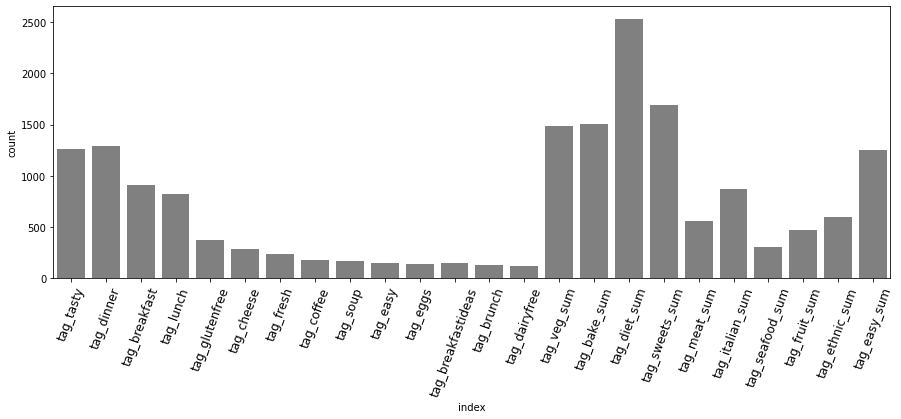

In [323]:
counts2 = pd.DataFrame(df.iloc[:,7:].sum(axis=0),columns=['count'])
counts2.reset_index(inplace=True)

plt.figure(figsize=(15,5))
plt.xticks(rotation=70, size=12)
sns.barplot(x=counts2['index'], y=counts2['count'], palette=['gray'])

______

In [46]:
labels = (df.iloc[:,7:]).to_numpy(dtype=bool)
mask = df.columns[7:]
new_col = []

for i in range(labels.shape[0]):
    new_col.append(list(mask[labels[i]]))
# fastai expects a string and not a list so ...
new_col2 = []
for row in new_col:
  t = ''
  for i in row:
    t += i + ','
  new_col2.append(t.strip())

col = pd.DataFrame(pd.Series(new_col2), columns=['labels'])
dataset = pd.concat([df_no_encoded_values.reset_index(drop=True), col.reset_index(drop=True)], axis=1)

In [47]:
dataset.loc[dataset['labels']==""]

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,labels
10,CMPDzLzrRvZ.png,https://www.instagram.com/p/CMPDzLzrRvZ/,food,72,2021-03-10T10:46:44,2021-03-10T11:49:47,1.05,
13,CMPDoNiAwsr.png,https://www.instagram.com/p/CMPDoNiAwsr/,food,10,2021-03-10T10:42:40,2021-03-10T11:50:02,1.12,
15,CMPDn7yJGtu.png,https://www.instagram.com/p/CMPDn7yJGtu/,food and indoor,32,2021-03-10T10:42:28,2021-03-10T11:50:10,1.13,
21,CMPDfLsHAy0.png,https://www.instagram.com/p/CMPDfLsHAy0/,saddle-stitched leather and purse,5,2021-03-10T10:41:31,2021-03-10T11:50:43,1.15,
23,CMPDbTEg8-n.png,https://www.instagram.com/p/CMPDbTEg8-n/,dessert,11,2021-03-10T10:40:45,2021-03-10T11:50:50,1.17,
...,...,...,...,...,...,...,...,...
11677,CMsOLWzApRu.png,https://www.instagram.com/p/CMsOLWzApRu/,food and indoor,11,2021-03-21T18:40:33,2021-03-22T10:07:20,15.45,
11683,CMsO9bIhncA.png,https://www.instagram.com/p/CMsO9bIhncA/,food,38,2021-03-21T18:39:30,2021-03-22T10:07:47,15.47,
11684,CMsOzmzh6nU.png,https://www.instagram.com/p/CMsOzmzh6nU/,dessert and indoor,92,2021-03-21T18:40:18,2021-03-22T10:07:52,15.46,
11688,CMsO1_ip0WW.png,https://www.instagram.com/p/CMsO1_ip0WW/,fruit and indoor,78,2021-03-21T18:43:45,2021-03-22T10:08:12,15.41,


### 4187 (3822 were intially) observations have no tag assigned to them.

In [48]:
# # Assigning a string "no_tag" to instances with empty tag
dataset.loc[dataset['labels']=="", 'labels'] = "no_tag"

# # Also clean the trailing commas
dataset['labels'] = dataset['labels'].str.rstrip(',')

Some claim that keeping in isntances with no target like these 'no_tag' images can be beneficial for the model to learn in self-supervised way, so trained the model once with these instances in the training dataset and another time without them. It seemed that the just added noise in the training process, while also causing the dataset to be hugely imbalanced.

In [49]:
dataset['labels'].value_counts()

no_tag                                                                    4059
tag_diet_sum                                                               511
tag_bake_sum                                                               328
tag_sweets_sum                                                             285
tag_bake_sum,tag_sweets_sum                                                262
                                                                          ... 
tag_tasty,tag_dinner,tag_lunch,tag_veg_sum,tag_diet_sum,tag_ethnic_sum       1
tag_tasty,tag_veg_sum,tag_diet_sum,tag_sweets_sum,tag_easy_sum               1
tag_glutenfree,tag_dairyfree,tag_veg_sum,tag_italian_sum                     1
tag_tasty,tag_breakfast,tag_brunch,tag_easy_sum                              1
tag_breakfast,tag_breakfastideas,tag_diet_sum,tag_ethnic_sum                 1
Name: labels, Length: 1422, dtype: int64

In [50]:
dataset['labels'] = dataset['labels'].replace(" ", "")
dataset.drop(dataset[dataset.labels=="no_tag"].index, inplace=True)

In [51]:
dataset.sample(5)

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,labels
9476,CMhZiRfjW09.png,https://www.instagram.com/p/CMhZiRfjW09/,food,260,2021-03-17T13:52:35,2021-03-17T17:01:06,3.14,tag_diet_sum
2564,CMNOkzhnHtg.png,https://www.instagram.com/p/CMNOkzhnHtg/,food and indoor,37,2021-03-09T18:33:43,2021-03-10T17:49:14,23.26,"tag_veg_sum,tag_bake_sum"
70,CMN9fxdFlKw.png,https://www.instagram.com/p/CMN9fxdFlKw/,food and indoor,86,2021-03-11T10:22:28,2021-03-12T13:08:36,26.77,"tag_dinner,tag_veg_sum"
3923,CMRSs2kF1_P.png,https://www.instagram.com/p/CMRSs2kF1_P/,dessert and strawberry,56,2021-03-11T07:46:47,2021-03-11T14:57:08,7.17,"tag_tasty,tag_sweets_sum"
262,CMO6nAShax2.png,https://www.instagram.com/p/CMO6nAShax2/,food and indoor,156,2021-03-10T09:23:42,2021-03-10T12:18:44,2.92,"tag_veg_sum,tag_ethnic_sum"


______
##### The model would keep crashing at a certain file, so we thought that certain images that could not be loaded in the model appropriately should removed. It turned out that only one file was corruped 

In [52]:
# import PIL
# # from tqdm import tqdm

# corrupted_files = 0
# corrupted_file_paths = []
# for img_file in (path.ls()):
#   try:
#     with Image.open(img_file) as f:
#       f.verify()
#   except:
#     corrupted_file_paths.append(img_file)
#     corrupted_files += 1
# print(f'Corrupted files found: {corrupted_files}')
# # print(str(corrupted_file_paths))

# # Creating a list of the files that are found to be corrupted
# for found in corrupted_file_paths:
#   cor_files_list = re.findall("\w+.png", str(found))

In [53]:
# # Delete those files from the Dataframe
# print(f"Initial DataFrame.shape: {dataset.shape}\n")
# for cor_file in cor_files_list:
#   dataset.drop(dataset[dataset['photo_id'] == cor_file].index, inplace=True)
#   print(f'{cor_file}  has been deleted')
# print(f"\nFinal DataFrame.shape:   {dataset.shape}")

In [54]:
# this one is to avoid running the previous two cells. Only on file is not working causing the fastai model to run into an error and stop training
dataset.drop(dataset[dataset['photo_id'] == 'CMmV2A2sBvY.png'].index, inplace=True)

_____

### Getting Fastai's API 'DataBlock' up and running

In [55]:
path = Path("./recipes")

In [56]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [57]:
def get_x(r): 
  return "./recipes/" + r['photo_id']

def get_y(r): 
  return r['labels'].split(",")

As stated at fastai's documentation here are two kind of augmentations: item_tfms and batch_tfms. Each do what it sounds like: an item transform is applied on an individual item basis, and a batch transform is applied over each batch of data. The role of the item transform is to prepare everything for a batch level (and to apply any specific item transformations you need), and the batch transform is to further apply any augmentations on the batch level efficently (normalization of your data also happens on a batch level).

In [58]:
# Splitting train/validation set
splitter = RandomSplitter(valid_pct=0.2, seed=1)

In [59]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x = get_x, 
                   get_y = get_y, 
                   splitter = splitter,
                   item_tfms = RandomResizedCrop(64, min_scale=0.35),
                   batch_tfms = aug_transforms(do_flip=True, 
                                               max_rotate=5.,
                                               pad_mode='zeros', 
                                               max_zoom=1.3,
                                               mult=2, 
                                               min_scale=0.5, 
                                               max_lighting=0.4,
                                               p_lighting=0.8)) # flip has 0.5 chance by default for do_flip

### item_tfms's visualization

AxesSubplot(0.125,0.536818;0.352273x0.343182)
AxesSubplot(0.547727,0.536818;0.352273x0.343182)
AxesSubplot(0.125,0.125;0.352273x0.343182)
AxesSubplot(0.547727,0.125;0.352273x0.343182)


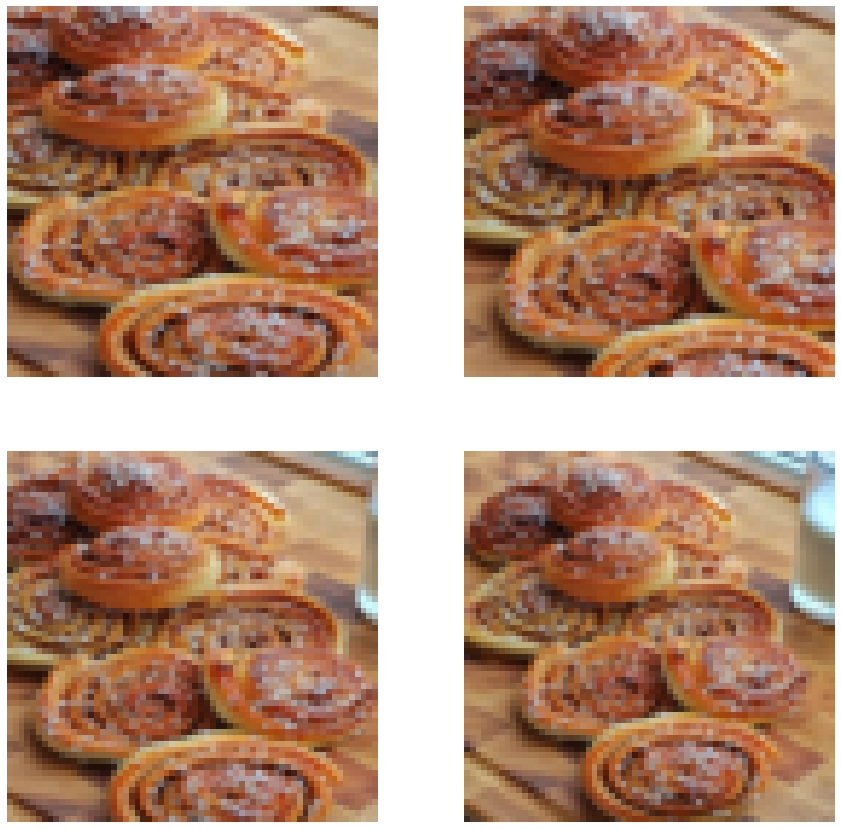

In [60]:
img_test_path = 'recipes/CF66vPaJAac.png'

img = PILImage(PILImage.create(img_test_path).resize((600,400)))

crop = RandomResizedCrop(64, min_scale=0.35)
_,axs = plt.subplots(2,2,figsize=(15,15))
for ax in axs.flatten():
    print(ax)
    cropped = crop(img)
    show_image(cropped, ctx=ax);

In [61]:
# How the data is split in train and validation data
splitter(dataset['photo_id'])

((#6110) [4444,6215,6675,7097,6961,4617,6427,7269,4037,3732...],
 (#1527) [5509,4096,7046,3127,2755,222,2275,1398,3787,4401...])

In [62]:
dsets = dblock.datasets(dataset);
dls = dblock.dataloaders(dataset, batch_size= 128);

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


A sample of a batch is demonstrated (with augmentations applied on each image, as specified previously). Of course,y only 9 out of the 128 images that a batch consists of are shown.

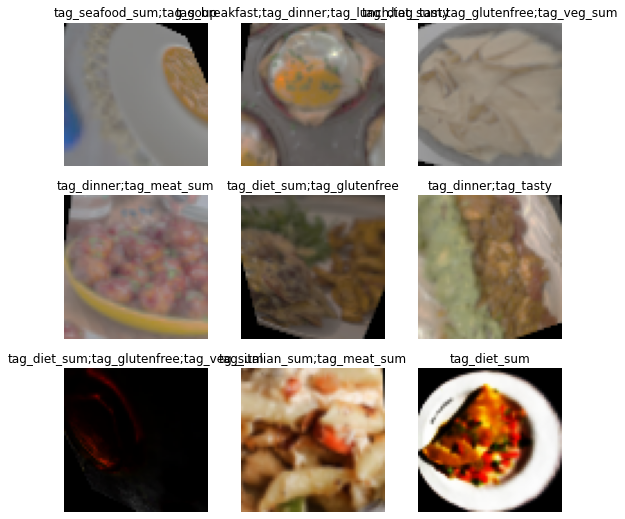

In [63]:
dls.show_batch()

In [64]:
## Just to make sure that everything is on Cuda

# import fastai
# fastai.learner.default_device()

Initially the following metrics were used, but in the end all of them were ignored during the training process

In [65]:
# # In the end these metrics were not used.

# acc_02 = partial(accuracy_multi, thresh=0.5)
# f1_score = F1ScoreMulti(thresh=0.5)
# fb_score = FBetaMulti(beta = 2, thresh=0.5)
# r_score = RecallMulti()
# p_score = PrecisionMulti()

___________
### Defining our model, a pretrained resnet18 and training it

In [66]:
# # To run the model with the metrics defined previously
# model = cnn_learner(dls, resnet18, pretrained=True,  metrics=[ f1_score, fb_score, r_score, p_score])

# To run the model without the metrics defined previously
model = cnn_learner(dls, resnet18, pretrained=True)

In [68]:
# # Shape of the first conv layer in case anyone wants to take a look
# next(model.named_parameters())[1].shape
# # The pretrained weight parameters
# next(model.named_parameters())[1]

##### Searching for a well-performing learning rate to use as a base_lr for fine_tuning the model. Two values are reported back by the function call, each of which corresponds to:
- one tenth of the minimum before the divergence
- when the slope is the steepest

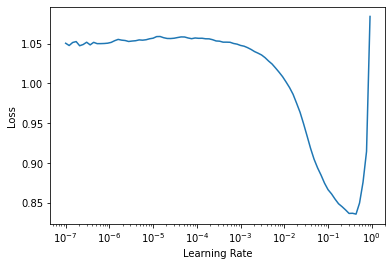

In [69]:
lr_ = model.lr_find()

In [70]:
# A couple of examples have no predictions that leads to a 0.0 division error. We use the following to silence the warning.
import warnings
warnings.filterwarnings("ignore")

In [71]:
model.fine_tune(epochs=15, base_lr=lr_[0], freeze_epochs=15)

epoch,train_loss,valid_loss,time
0,0.781344,0.499366,02:08
1,0.485502,0.321449,02:12
2,0.374997,0.311537,02:06
3,0.332219,0.300511,02:06
4,0.313249,0.316015,02:05
5,0.303413,0.296638,01:57
6,0.294805,0.277004,02:04
7,0.285983,0.274117,01:55
8,0.280332,0.272165,01:55
9,0.278921,0.274620,02:01


epoch,train_loss,valid_loss,time
0,0.277627,0.271630,02:04
1,0.275142,0.270805,02:06
2,0.275052,0.273454,02:01
3,0.276973,0.272790,02:01
4,0.277415,0.289770,02:01
5,0.276961,0.283857,01:55
6,0.277038,0.272810,01:59
7,0.276347,0.273734,01:58
8,0.273940,0.272182,02:00
9,0.272250,0.272015,01:57


Path('models/resnet18_v3.pth')

In [96]:
# model.load('resnet18_v2_0')

In [76]:
# model.recorder.plot_lr_find()

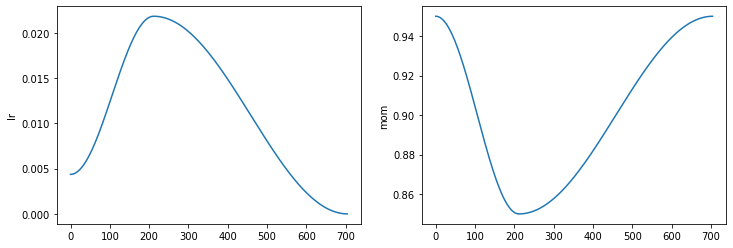

In [74]:
# LR scheduler - fine_tune
model.recorder.plot_sched()

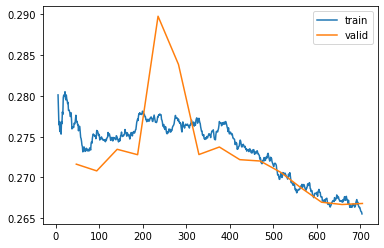

In [75]:
model.recorder.plot_loss()

In [90]:
# model.summary()

In [328]:
model.export('resnet18.pkl')
model.save('resnet18_v4')

Path('models/resnet18_v4.pth')

________
## Make predictions

In [329]:
import ipywidgets as widgets
import io

In [330]:
def my_predict_func(predicted_probabilities, request_number=3, targets=dls.vocab):
    """The dataset is so noisy that we aim for the top 3 (or more if requested) labels as predicted from the model"""
    val, ind = torch.topk(predicted_probabilities, request_number)
    target_list = list(targets)
    labels = []
    for num, i in enumerate(ind):
        labels.append(target_list[ind[num]])
    return labels

##### It is mandatory that the image that is fed into the model is resized so that it fits the input space of the model.
##### The image found at the [link](https://www.instagram.com/p/CPdnovJLYsK/) was used as a test image - the tag/labels can be found there as well

### - Either this cell can be used to directly load in a test_img

In [338]:
# img_test = PILImage(PILImage.create('./v1.png').resize((600,400)))

### - Or the following two cells

In [332]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [339]:
for name, file_info in uploader.value.items():
    img_test = PILImage(PILImage.create(io.BytesIO(file_info['content'])))

While testing an image we dont want to randomly crop and resize like we did while training, but instead we use the RatioResize function offered by fastai, that just rescales the image

In [340]:
resize = RatioResize(64)
_,_,preds= model.predict(resize(img_test))

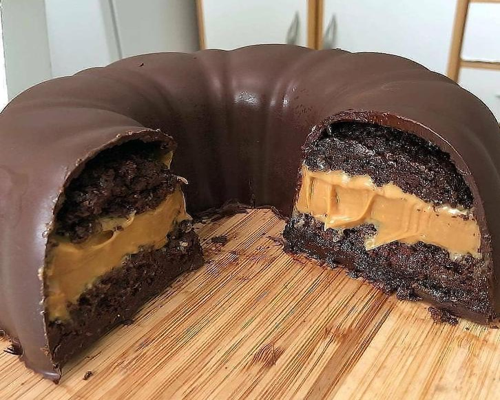

In [341]:
# Visualize the img_test (raw/unprocessed)
img_test.resize((500,400))

### And our model's predictions:

In [342]:
my_predict_func(preds, request_number=2)

['tag_sweets_sum', 'tag_bake_sum']

We also setup the following metric which is similiar to a Multilabel-Recall metric, that focuses on the 3 most dominant labels.

In [281]:
def my_metric()
    preds_,targs_ = model.get_preds()

    total_found = 0
    total_missed = 0
    for i in range(1):
        found = 0
        missed = 0
        predicted_probabilities, true_labels= (preds_[100], targs_[100])
        total_true_labels = true_labels.sum()
        k = min(request_number, int(total_true_labels.item()))
        val, ind = torch.topk(predicted_probabilities, k)
        for i in range(k):
            if true_labels[ind[i]]== 1:
                found += 1
            else:
                missed += 1
        total_found += found
        total_missed += missed
    print(f'{total_found/(total_found+total_missed) * 100}%')

80.0%


____________

## Some interesting stuff

In [210]:
model = models.resnet18(pretrained=True)

In [211]:
preprocess = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()])

In [212]:
img_test = preprocess(Image.open('./recipes/CF66vPaJAac.png').convert('RGB'))

In [213]:
img_test.shape

torch.Size([3, 71, 64])

torch.Size([1, 64, 36, 32])


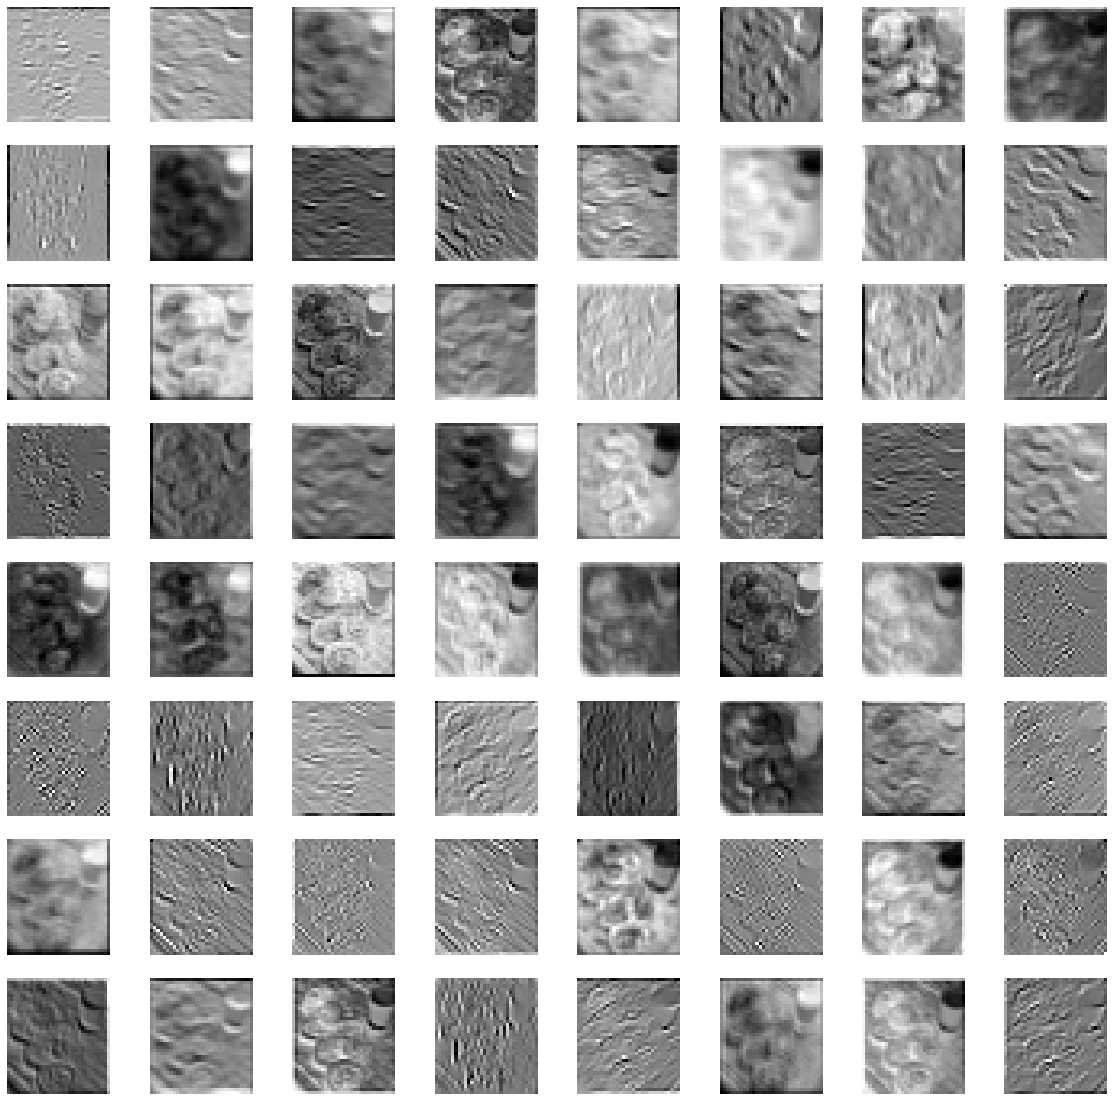

In [214]:
temp = model.conv1(img_test.unsqueeze(0))
print(temp.shape)

fig, ax = plt.subplots(8,8, figsize = (20,20))
k=0
for i in range(8):
  for j in range(8):
    ax[i,j].imshow(temp.squeeze(0)[k].detach().numpy(), cmap='gray')
    ax[i,j].axis('off')
    k += 1
fig.savefig('what_the_net_sees.png')

In [221]:
def plot_convolved_features(layer):
    """
    Only works for RGB convolutions (in_channel=3), which basically means it works only on the first conv layer of a net.
    """
    layer = layer.to('cpu')
    k = 0
    N = layer.weight.shape[0]
    n = np.ceil(np.sqrt(N)).astype(np.int16)
    fig, ax = plt.subplots(n,n, figsize = (10,10))
    with torch.no_grad():
        for i in range(n):
            for j in range(n):
                ax[i,j].imshow(layer.weight[k].permute(1,2,0), cmap='gray'); 
                k += 1
                ax[i,j].axis('off')
    fig.savefig('conv1_features.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

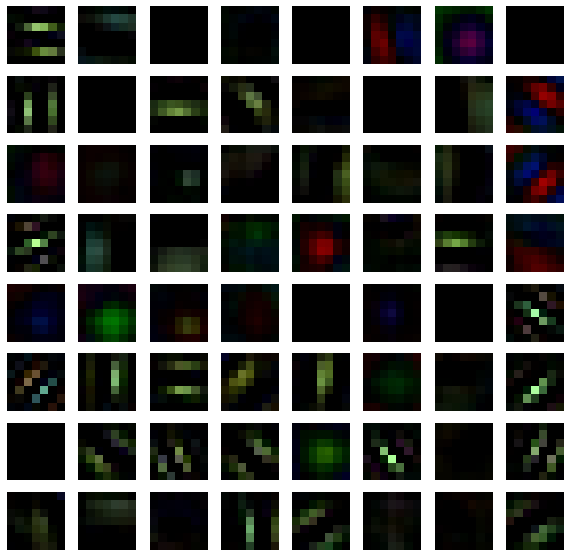

In [222]:
plot_convolved_features(model.conv1);